Initial Data Preview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365     71053                  WHITE METAL LANTERN         6   
1    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
2    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
4    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       3.39       17850  United Kingdom  
1  12/1/2010 8:26       2.75       17850  United Kingdom  
2  12/1/2010 8:26       3.39       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       7.65       17850  United Kingdom  

RFM Table:
   CustomerID  Recency  Frequency  Monetary
0       12346      325          1  77183.60
1       12347        1        182   4310.00
2       12348       74         31   1797.24
3  

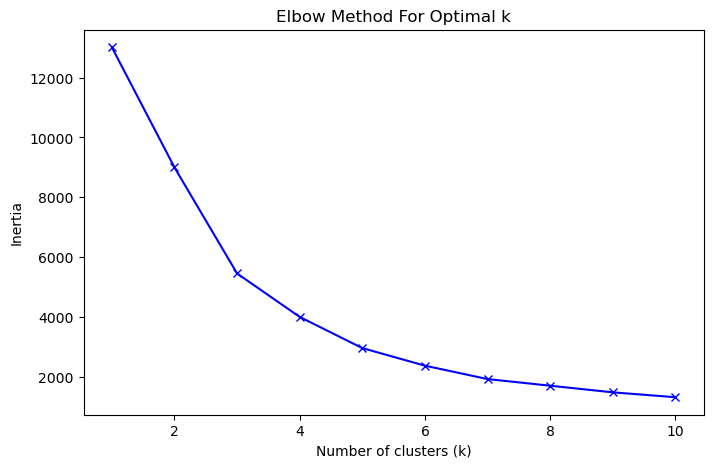

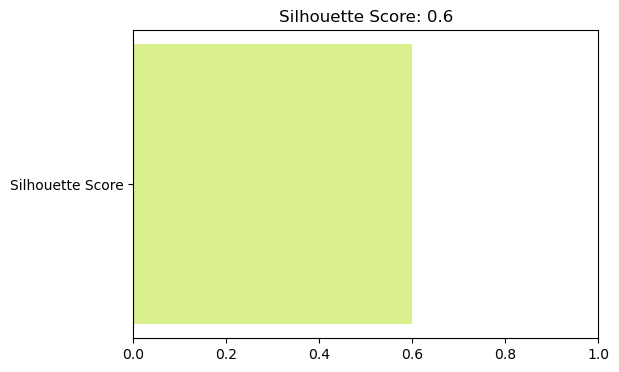

Silhouette Score: 0.6

RFM Table Summary:


,Cluster,Recency_Min,Recency_Mean,Recency_Max,Frequency_Min,Frequency_Mean,Frequency_Max,Monetary_Min,Monetary_Mean,Monetary_Max,Customer_Count
0,0,0,40.410000,155,1,104.290000,2700,0.000000,2063.150000,81024.840000,3250
1,1,139,246.500000,373,1,27.660000,296,3.750000,636.550000,77183.600000,1078
2,2,0,1.000000,3,4596,5807.750000,7847,33719.730000,70925.290000,143825.060000,4
3,3,0,6.000000,23,3,847.140000,2080,91062.380000,176606.160000,280206.020000,7


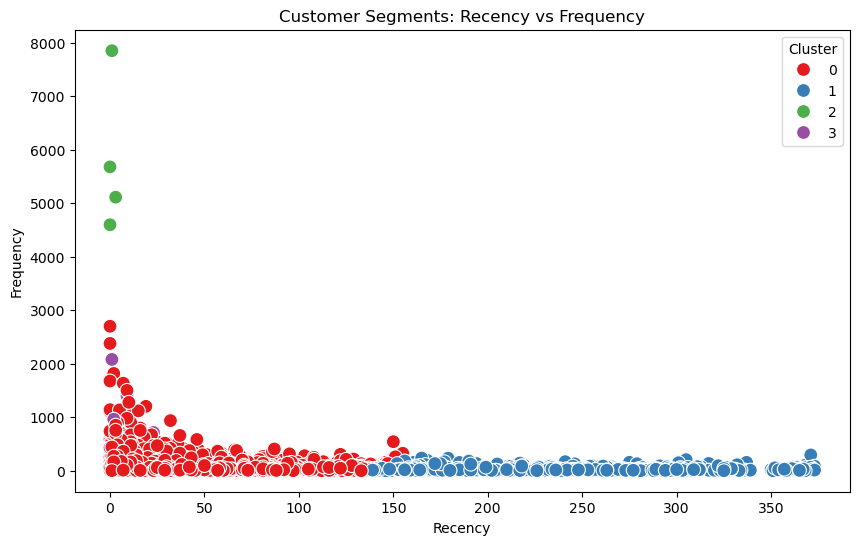


Customer Counts per Cluster (Recency vs Frequency):


,Cluster,Customer_Count
0,0,3250
1,1,1078
2,2,4
3,3,7


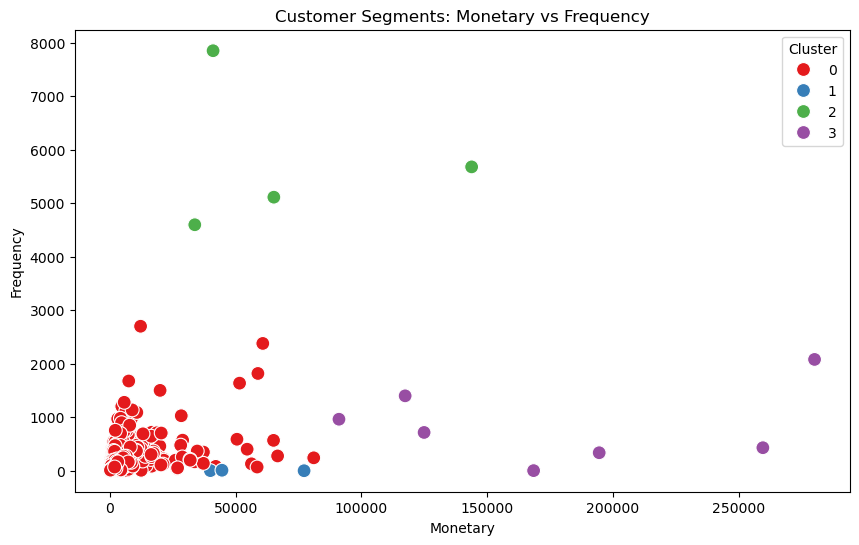


Monetary Sum per Cluster (Monetary vs Frequency):


,Cluster,Monetary_Sum
0,0,6705232.190000
1,1,686201.260000
2,2,283701.150000
3,3,1236243.150000


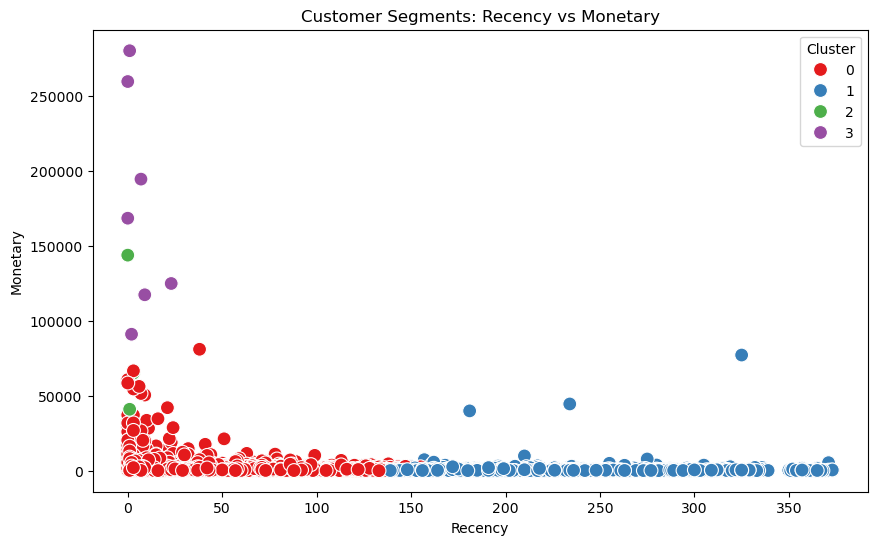


Customer Counts per Cluster (Recency vs Monetary):


,Cluster,Customer_Count
0,0,3250
1,1,1078
2,2,4
3,3,7



Cluster Analysis:


,Cluster,Recency_Mean,Recency_Median,Frequency_Mean,Frequency_Median,Monetary_Mean,Monetary_Median,Monetary_Sum,Customer_Count
0,0,40.410000,29.000000,104.290000,57.000000,2063.150000,922.260000,6705232.190000,3250
1,1,246.500000,242.000000,27.660000,18.000000,636.550000,309.920000,686201.260000,1078
2,2,1.000000,0.500000,5807.750000,5394.000000,70925.290000,53078.180000,283701.150000,4
3,3,6.000000,2.000000,847.140000,716.000000,176606.160000,168472.500000,1236243.150000,7



Classifier Performance:
Accuracy: 1.0 - Proportion of correct predictions out of total predictions.
Precision: 1.0 - Proportion of true positive predictions out of all positive predictions made.
Recall: 1.0 - Proportion of true positive predictions out of all actual positives.
F1-Score: 1.0 - Harmonic mean of precision and recall, giving a single performance score.


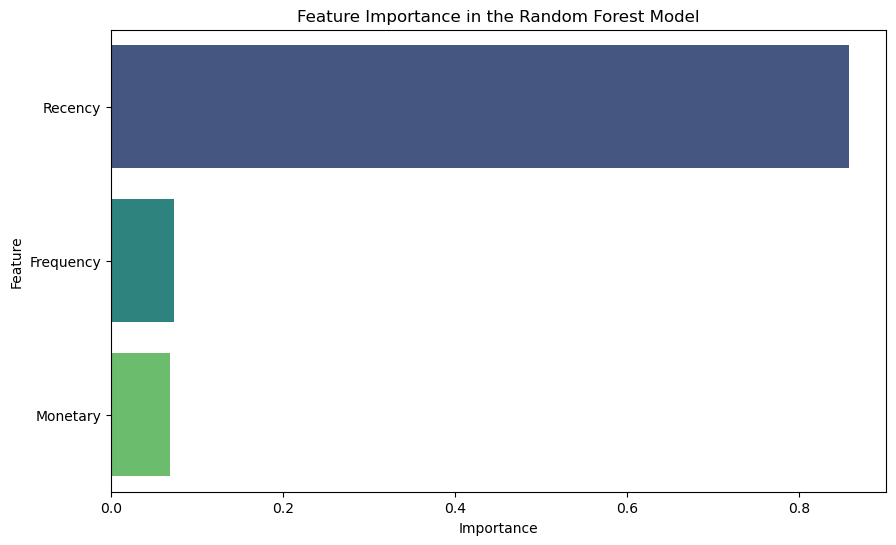

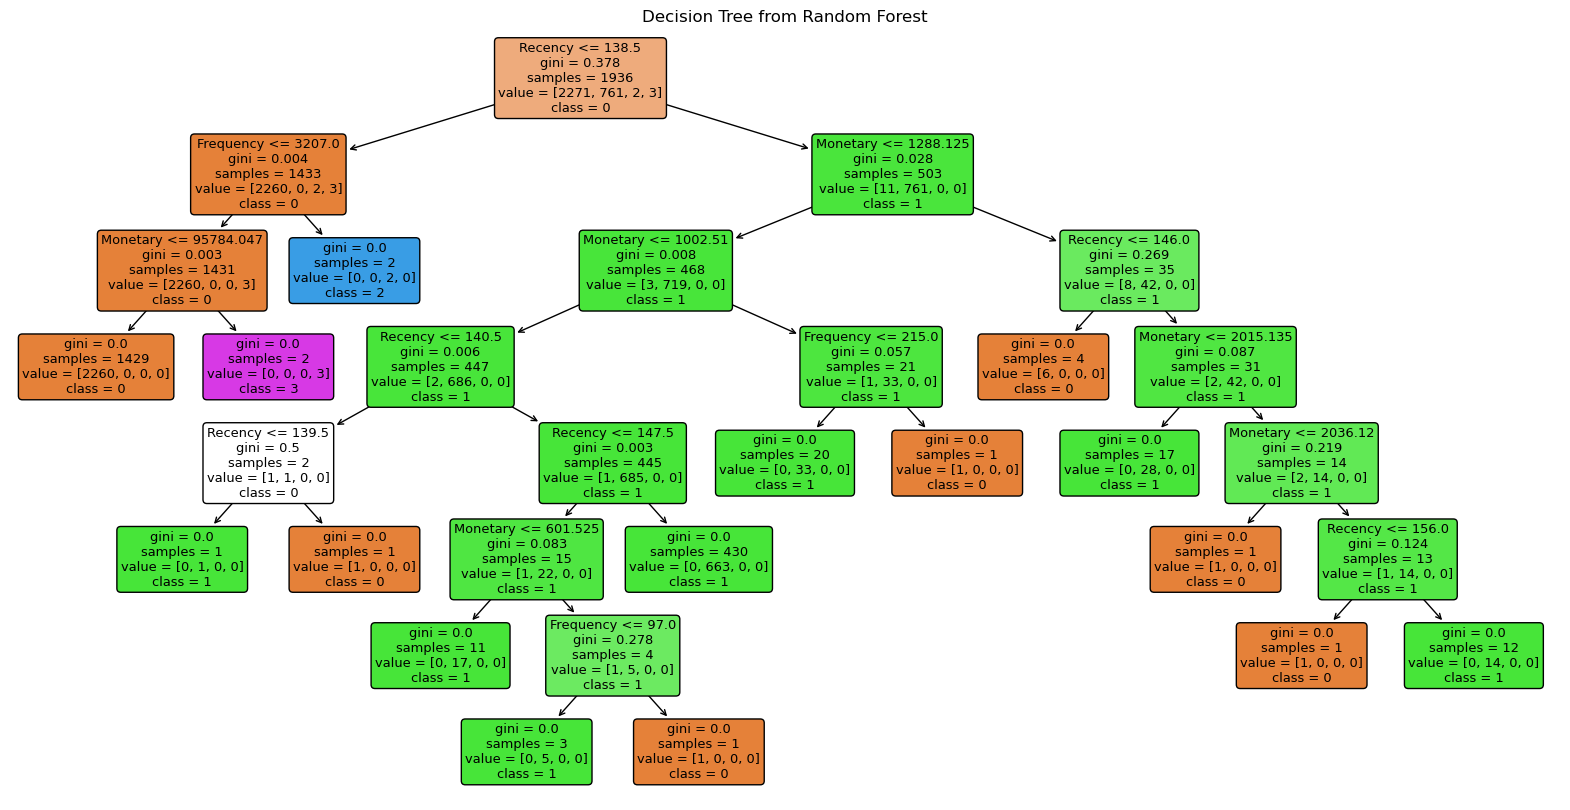

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np

# Step 1: Load the Dataset
file_path = 'C:/Users/naren/Online_Retail_db.csv'  # Local file path
df = pd.read_csv(file_path)

# Display the first few rows
print("Initial Data Preview:")
print(df.head())

# Step 2: Data Preprocessing
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter out cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].str.startswith('C')]

# Calculate Recency
latest_date = df['InvoiceDate'].max()
df['Recency'] = (latest_date - df['InvoiceDate']).dt.days

# Calculate Monetary Value
df['Monetary'] = df['Quantity'] * df['UnitPrice']

# Step 3: Calculate RFM (Recency, Frequency, Monetary) values for each customer
rfm = df.groupby('CustomerID').agg({
    'Recency': 'min',             # Recency is the minimum number of days since the last purchase
    'InvoiceNo': 'count',         # Frequency is the total number of transactions
    'Monetary': 'sum'             # Monetary is the sum of all purchases
}).reset_index()

# Rename columns for clarity
rfm.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Round values to 2 decimal points
rfm = rfm.round(2)

# Display the RFM table with cluster analysis
print("\nRFM Table:")
print(rfm.head())

# Step 4: Determine the optimal number of clusters using the Elbow Method
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 5: Apply K-Means Clustering with the chosen number of clusters (let's say k=4 based on the Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 6: Evaluate the clustering using Silhouette Score
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])

# Display the Silhouette Score prominently with a color gradient from red to green
plt.figure(figsize=(6, 4))
# Use a gradient from red (bad) to green (good)
cmap = sns.color_palette("RdYlGn", as_cmap=True)
color = cmap(silhouette_avg)

plt.barh(['Silhouette Score'], [round(silhouette_avg, 2)], color=color)
plt.xlim(0, 1)
plt.title(f'Silhouette Score: {round(silhouette_avg, 2)}')
plt.show()

print(f"Silhouette Score: {round(silhouette_avg, 2)}")

# Step 7: Visualize the Customer Segments
# Define the color palette for clusters
palette = sns.color_palette("Set1", n_colors=len(rfm['Cluster'].unique()))

def display_customer_counts(rfm, title):
    customer_counts = rfm['Cluster'].value_counts().sort_index()
    customer_counts_df = pd.DataFrame({
        'Cluster': customer_counts.index,
        'Customer_Count': customer_counts.values
    })

    styled_customer_counts = customer_counts_df.style.applymap(lambda x: f'background-color: {mcolors.to_hex(palette[int(x)])}', subset=['Cluster'])

    print(f"\nCustomer Counts per Cluster ({title}):")
    display(styled_customer_counts)

def display_monetary_sum(rfm, title):
    monetary_sum = rfm.groupby('Cluster')['Monetary'].sum().sort_index()
    monetary_sum_df = pd.DataFrame({
        'Cluster': monetary_sum.index,
        'Monetary_Sum': monetary_sum.values
    })

    styled_monetary_sum = monetary_sum_df.style.applymap(lambda x: f'background-color: {mcolors.to_hex(palette[int(x)])}', subset=['Cluster'])

    print(f"\nMonetary Sum per Cluster ({title}):")
    display(styled_monetary_sum)
# Display the RFM Table Summary with color coding
rfm_summary = rfm.groupby('Cluster').agg({
    'Recency': ['min', 'mean', 'max'],
    'Frequency': ['min', 'mean', 'max'],
    'Monetary': ['min', 'mean', 'max'],
    'CustomerID': 'count'
}).reset_index()

rfm_summary.columns = ['Cluster', 'Recency_Min', 'Recency_Mean', 'Recency_Max', 
                       'Frequency_Min', 'Frequency_Mean', 'Frequency_Max',
                       'Monetary_Min', 'Monetary_Mean', 'Monetary_Max',
                       'Customer_Count']

# Round values to 2 decimal points
rfm_summary = rfm_summary.round(2)

# Color coding for better understanding
rfm_summary_styled = rfm_summary.style.background_gradient(cmap='coolwarm', subset=['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean', 'Customer_Count'])

print("\nRFM Table Summary:")
display(rfm_summary_styled)

# Plotting Recency vs Frequency colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette=palette, s=100)
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

# Recalculate and display Customer Counts per Cluster after the plot
display_customer_counts(rfm, "Recency vs Frequency")

# Plotting Monetary vs Frequency colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster', data=rfm, palette=palette, s=100)
plt.title('Customer Segments: Monetary vs Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

# Display Monetary Sum per Cluster after the plot
display_monetary_sum(rfm, "Monetary vs Frequency")

# Plotting Recency vs Monetary colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette=palette, s=100)
plt.title('Customer Segments: Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()

# Recalculate and display Customer Counts per Cluster after the plot
display_customer_counts(rfm, "Recency vs Monetary")

# Step 8: Cluster Analysis with color coding
# Analyze the characteristics of each cluster
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'sum'],
    'CustomerID': 'count'
}).reset_index()

cluster_analysis.columns = ['Cluster', 'Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median',
                            'Monetary_Mean', 'Monetary_Median', 'Monetary_Sum', 'Customer_Count']

# Round specific values to 2 decimal points
cluster_analysis[['Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median',
                  'Monetary_Mean', 'Monetary_Median', 'Monetary_Sum']] = cluster_analysis[[
    'Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median',
    'Monetary_Mean', 'Monetary_Median', 'Monetary_Sum']].round(2)

# Using color coding for better visual interpretation in a DataFrame
styled_cluster_analysis = cluster_analysis.style.background_gradient(cmap='coolwarm', subset=['Monetary_Sum'])

print("\nCluster Analysis:")
display(styled_cluster_analysis)  # Display the DataFrame with styling

# Step 9: Building a Classifier (Optional)
# Split the data into training and testing sets
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred, average='weighted'), 2)
recall = round(recall_score(y_test, y_pred, average='weighted'), 2)
f1 = round(f1_score(y_test, y_pred, average='weighted'), 2)

print("\nClassifier Performance:")
print(f"Accuracy: {accuracy} - Proportion of correct predictions out of total predictions.")
print(f"Precision: {precision} - Proportion of true positive predictions out of all positive predictions made.")
print(f"Recall: {recall} - Proportion of true positive predictions out of all actual positives.")
print(f"F1-Score: {f1} - Harmonic mean of precision and recall, giving a single performance score.")

# Get feature importances from the trained Random Forest model
importances = clf.feature_importances_
features = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Feature Importance in the Random Forest Model')
plt.show()

# Convert the feature names to a list
features = X_train.columns.tolist()

# Visualize one of the trees in the Random Forest
plt.figure(figsize=(20, 10))
tree = clf.estimators_[0]  # Choose the first tree in the forest
plot_tree(tree, feature_names=features, filled=True, rounded=True, class_names=[str(i) for i in clf.classes_])
plt.title('Decision Tree from Random Forest')
plt.show()
